# NAO analysis in FOCI-OpenIFS AGRIF

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cmocean 
from eofs.xarray import Eof
from scipy.stats import linregress

In [2]:
#pip install eofs

Note: you may need to restart the kernel to use updated packages.


In [92]:
def calculate_eof(da_msl, neofs=1, npcs=10):
    # First remove seasonal cycle
    da_msl_anom = da_msl.groupby('time.month') - da_msl.groupby('time.month').mean('time')
    
    # We need weights for grid area
    #weights = np.tile( np.cos(np.deg2rad(da_msl_anom['lat'].values)), (da_msl_anom['lon'].shape[0],1) ).T
    coslat = np.cos(np.deg2rad(da_msl_anom.coords['lat'].values)).clip(0., 1.)
    weights = np.sqrt(coslat)[..., np.newaxis]
    
    # calculate EOF and PC
    #solver = Eof(da_msl_anom.values, weights = weights)
    solver = Eof(da_msl_anom, weights=weights)
    eofs   = solver.eofs(neofs = neofs)
    #eofs   = solver.eofsAsCovariance(neofs=neofs)
    pcs    = solver.pcs(npcs = npcs)
    
    # get explained variances
    explained_variance = solver.varianceFraction(neigs=10)
    
    # Put data in DataArray
    da_eofs = xr.DataArray(eofs, dims=("eof", "lat", "lon"), coords={"lon": da_msl['lon'], "lat": da_msl['lat'], "eof": np.arange(1,neofs+1)})
    da_pcs  = xr.DataArray(pcs,  dims=("time", "eof"), coords={"time": da_msl['time'], "eof": np.arange(1,npcs+1)})
    
    return da_eofs, da_pcs

## Sea-level pressure data

In [93]:
scale = 1e-2

# FOCI-LR
foci_lr = '/sfs/fs1/work-geomar/smomw352/foci_analysis/foci_JJK001_pmpi_1m_19500101_19791231_GG_surface_r360x180_180.nc'
ds_foci_lr = xr.open_dataset(foci_lr)
msl_foci_lr = ds_foci_lr['MSL']
na_msl_foci_lr = msl_foci_lr.sel(lon=slice(-90,40),lat=slice(20,80)) * scale
eof_msl_foci_lr, pc_msl_foci_lr = calculate_eof(na_msl_foci_lr)

# FOCI-LR-NEST
foci_lr_nest = '/sfs/fs1/work-geomar/smomw352/foci_analysis/foci_JJK002_29_1m_19500101_19791231_GG_surface_r360x180_180.nc'
ds_foci_lr_nest = xr.open_dataset(foci_lr_nest)
msl_foci_lr_nest = ds_foci_lr_nest['MSL']
na_msl_foci_lr_nest = msl_foci_lr_nest.sel(lon=slice(-90,40),lat=slice(20,80)) * scale
eof_msl_foci_lr_nest, pc_msl_foci_lr_nest = calculate_eof(na_msl_foci_lr_nest)

# FOCI-HR-NEST
foci_hr_nest = '/sfs/fs1/work-geomar/smomw352/foci_analysis/foci_JJK005_6_1m_19500101_19791231_GG_surface_r360x180_180.nc'
ds_foci_hr_nest = xr.open_dataset(foci_hr_nest)
msl_foci_hr_nest = ds_foci_hr_nest['MSL']
na_msl_foci_hr_nest = msl_foci_hr_nest.sel(lon=slice(-90,40),lat=slice(20,80)) * scale
eof_msl_foci_hr_nest, pc_msl_foci_hr_nest = calculate_eof(na_msl_foci_hr_nest)

# FOCI-HR
foci_hr = '/sfs/fs1/work-geomar/smomw352/foci_analysis/foci_JJK006_3_1m_19500101_19791231_GG_surface_r360x180_180.nc'
ds_foci_hr = xr.open_dataset(foci_hr)
msl_foci_hr = ds_foci_hr['MSL']
na_msl_foci_hr = msl_foci_hr.sel(lon=slice(-90,40),lat=slice(20,80)) * scale
eof_msl_foci_hr, pc_msl_foci_hr = calculate_eof(na_msl_foci_hr)

## SLP time series

NAO is the difference in SLP between Reykjavik and Lisbon. Let's calculate this!

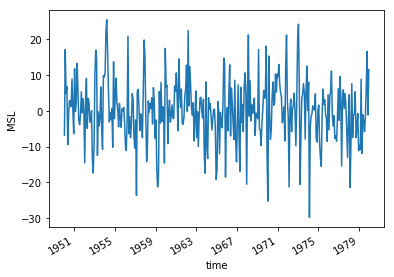

In [94]:
fig, ax = plt.subplots(1,1)
msl_lr_anom = na_msl_foci_lr.groupby('time.month') - na_msl_foci_lr.groupby('time.month').mean('time')
# Reykjavik: 64.1466° N, 21.9426° W
rey_msl_lr = msl_lr_anom.sel(lon = [-21.9426], lat = [64.1466], method="nearest").squeeze()
# Lisbon: 38.7253° N, 9.15° W
lis_msl_lr = msl_lr_anom.sel(lon = [-9.15], lat = [38.7253], method="nearest").squeeze()
(lis_msl_lr - rey_msl_lr).plot(ax=ax)

/sfs/fs6/home-geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:444: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # will not work for two columns.
/sfs/fs6/home-geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:444: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # will not work for two columns.
/sfs/fs6/home-geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:444: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # will not work for two columns.
/sfs/fs6/home-geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:444: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # will not work

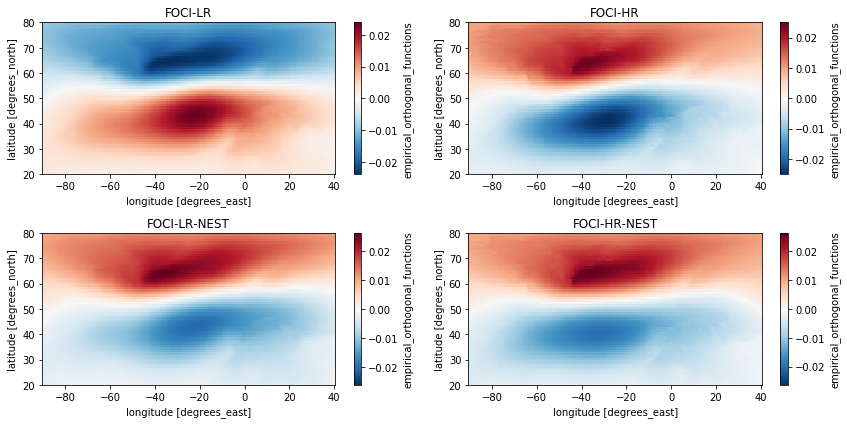

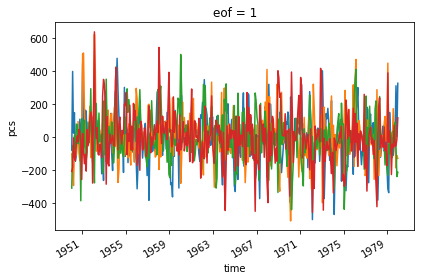

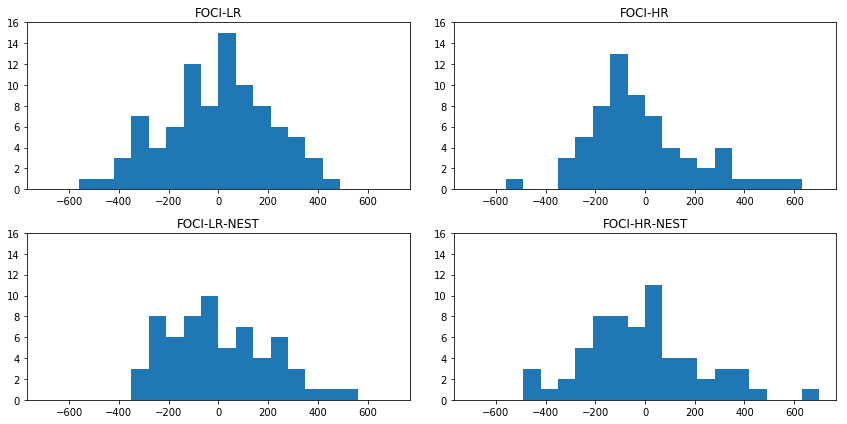

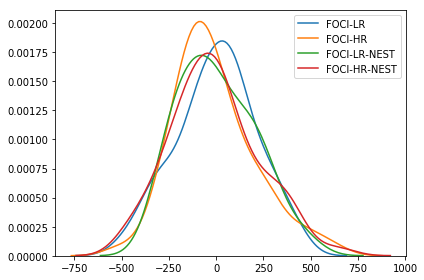

In [95]:
# Plot North Atlantic EOF
fig1, axes = plt.subplots(2,2,figsize=(12,6))
axs = axes.flat
eof_msl_foci_lr.sel(eof=1).plot(ax=axs[0])
eof_msl_foci_hr.sel(eof=1).plot(ax=axs[1])
eof_msl_foci_lr_nest.sel(eof=1).plot(ax=axs[2])
eof_msl_foci_hr_nest.sel(eof=1).plot(ax=axs[3])
axs[0].set_title('FOCI-LR')
axs[1].set_title('FOCI-HR')
axs[2].set_title('FOCI-LR-NEST')
axs[3].set_title('FOCI-HR-NEST')
fig1.tight_layout()

fig2, axs = plt.subplots(1,1)
pc_msl_foci_lr.sel(eof=1).plot(ax=axs,label='FOCI-LR')
pc_msl_foci_hr.sel(eof=1).plot(ax=axs,label='FOCI-HR')
pc_msl_foci_lr_nest.sel(eof=1).plot(ax=axs,label='FOCI-LR-NEST')
pc_msl_foci_hr_nest.sel(eof=1).plot(ax=axs,label='FOCI-HR-NEST')
fig2.tight_layout()

seasons = pc_msl_foci_lr.time.dt.season

fig3, axes = plt.subplots(2,2,figsize=(12,6))
axs = axes.flat
bins = np.linspace(-7,7,21) * 1e2
axs[0].set_title('FOCI-LR')
axs[0].hist(pc_msl_foci_lr.sel(eof=1).where(seasons == 'DJF').values,bins=bins)
axs[1].set_title('FOCI-HR')
axs[1].hist(pc_msl_foci_hr.sel(eof=1).where(seasons == 'DJF').values,bins=bins)
axs[2].set_title('FOCI-LR-NEST')
axs[2].hist(pc_msl_foci_lr_nest.sel(eof=1).where(seasons == 'DJF').values,bins=bins)
axs[3].set_title('FOCI-HR-NEST')
axs[3].hist(pc_msl_foci_hr_nest.sel(eof=1).where(seasons == 'DJF').values,bins=bins)
for ax in axs:
    ax.set_ylim([0,16])
    #ax.set_ylim([0,2e-5])
fig3.tight_layout()

fig4, ax = plt.subplots(1,1)
sns.distplot(pc_msl_foci_lr.sel(eof=1).where(seasons == 'DJF').values,bins=bins,ax=ax,kde=True,hist=False,label='FOCI-LR')
sns.distplot(pc_msl_foci_hr.sel(eof=1).where(seasons == 'DJF').values,bins=bins,ax=ax,kde=True,hist=False,label='FOCI-HR')
sns.distplot(pc_msl_foci_lr_nest.sel(eof=1).where(seasons == 'DJF').values,bins=bins,ax=ax,kde=True,hist=False,label='FOCI-LR-NEST')
sns.distplot(pc_msl_foci_hr_nest.sel(eof=1).where(seasons == 'DJF').values,bins=bins,ax=ax,kde=True,hist=False,label='FOCI-HR-NEST')
ax.legend()
fig4.tight_layout()
fig4.savefig('nao_fitted_pdf.eps',format='eps')

Now let's regress some variables onto NAO the index

In [96]:
# Load surface data
foci_lr = '/sfs/fs1/work-geomar/smomw352/foci_analysis/foci_JJK001_pmpi_1m_19500101_19791231_GG_surface_r360x180.nc'
ds_foci_lr = xr.open_dataset(foci_lr)

foci_lr_nest = '/sfs/fs1/work-geomar/smomw352/foci_analysis/foci_JJK002_29_1m_19500101_19791231_GG_surface_r360x180.nc'
ds_foci_lr_nest = xr.open_dataset(foci_lr_nest)

foci_hr_nest = '/sfs/fs1/work-geomar/smomw352/foci_analysis/foci_JJK005_6_1m_19500101_19791231_GG_surface_r360x180.nc'
ds_foci_hr_nest = xr.open_dataset(foci_hr_nest)

foci_hr = '/sfs/fs1/work-geomar/smomw352/foci_analysis/foci_JJK006_3_1m_19500101_19791231_GG_surface_r360x180.nc'
ds_foci_hr = xr.open_dataset(foci_hr)

# Remove seasonal cycle
da_t2m = []
da_shf = []
da_tp  = []
for ds in [ds_foci_lr, ds_foci_lr_nest, ds_foci_hr_nest, ds_foci_hr]:
    anom = ds['T2M'].groupby('time.month') - ds['T2M'].groupby('time.month').mean('time')
    da_t2m.append(anom)
    
    anom_sshf = ds['SSHF'].groupby('time.month') - ds['SSHF'].groupby('time.month').mean('time')
    anom_slhf = ds['SLHF'].groupby('time.month') - ds['SLHF'].groupby('time.month').mean('time')
    da_shf.append(anom_sshf + anom_slhf)
    
    anom = ds['TP'].groupby('time.month') - ds['TP'].groupby('time.month').mean('time')
    da_tp.append(anom)

[t2m_foci_lr_anom, t2m_foci_lr_nest_anom, t2m_foci_hr_nest_anom, t2m_foci_hr_anom] = da_t2m
[shf_foci_lr_anom, shf_foci_lr_nest_anom, shf_foci_hr_nest_anom, shf_foci_hr_anom] = da_shf
[ tp_foci_lr_anom,  tp_foci_lr_nest_anom,  tp_foci_hr_nest_anom,  tp_foci_hr_anom] = da_tp

In [97]:
def lin_regress(x, y):
    reg_slope, intercept, rval, pval, stderr = linregress(x, y)
    #res = np.stack(reg_slope,rval)
    return reg_slope

# NAO indices
nao_foci_lr = pc_msl_foci_lr.sel(eof=1)
nao_foci_hr = -pc_msl_foci_hr.sel(eof=1)
nao_foci_lr_nest = -pc_msl_foci_lr_nest.sel(eof=1)
nao_foci_hr_nest = -pc_msl_foci_hr_nest.sel(eof=1)

## Regress 2m temp onto NAO

In [98]:
t2m_regress_foci_lr = xr.apply_ufunc(lin_regress, nao_foci_lr, t2m_foci_lr_anom, 
                     vectorize = True, dask = 'parallelized', 
                     input_core_dims = [['time'], ['time']], output_dtypes = ['d']).compute()

t2m_regress_foci_lr_nest = xr.apply_ufunc(lin_regress, nao_foci_lr_nest, t2m_foci_lr_nest_anom, 
                                     vectorize = True, dask = 'parallelized', 
                                     input_core_dims = [['time'], ['time']], output_dtypes = ['d']).compute()

t2m_regress_foci_hr_nest = xr.apply_ufunc(lin_regress, nao_foci_hr_nest, t2m_foci_hr_nest_anom, 
                                     vectorize = True, dask = 'parallelized', 
                                     input_core_dims = [['time'], ['time']], output_dtypes = ['d']).compute()

t2m_regress_foci_hr = xr.apply_ufunc(lin_regress, nao_foci_hr, t2m_foci_hr_anom, 
                                     vectorize = True, dask = 'parallelized', 
                                     input_core_dims = [['time'], ['time']], output_dtypes = ['d']).compute()

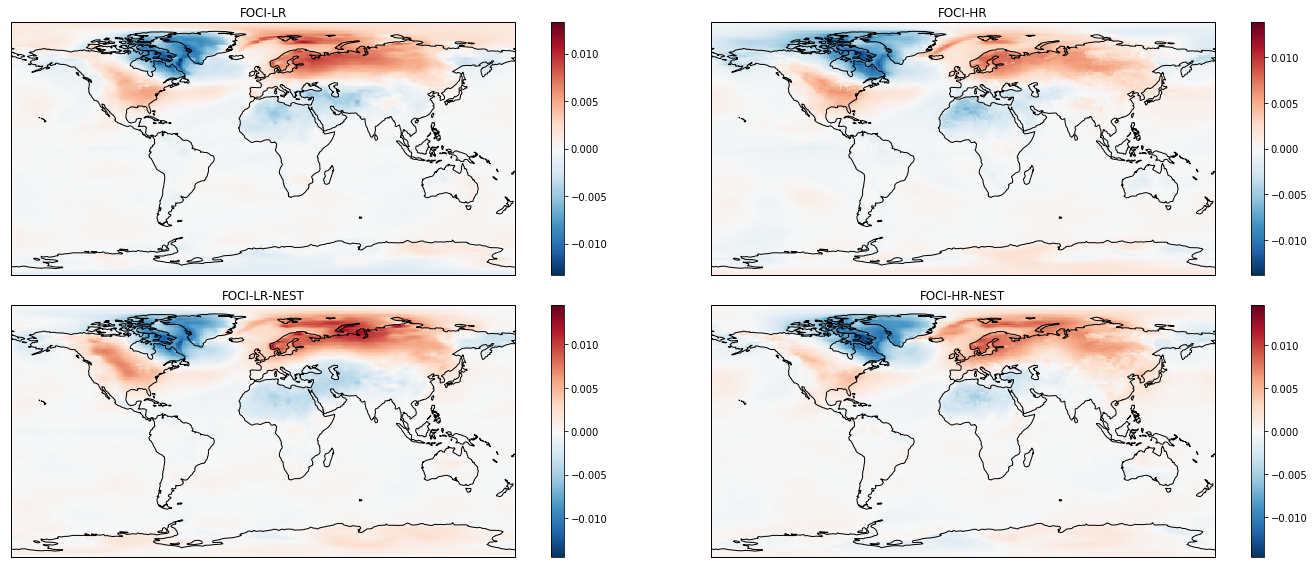

In [99]:
prj = ccrs.PlateCarree()
fig = plt.figure(figsize=(20,8))
axs = []
axs.append( fig.add_subplot(2,2,1,projection=prj) )
axs.append( fig.add_subplot(2,2,2,projection=prj) )
axs.append( fig.add_subplot(2,2,3,projection=prj) )
axs.append( fig.add_subplot(2,2,4,projection=prj) )

t2m_regress_foci_lr.plot(ax=axs[0])
t2m_regress_foci_hr.plot(ax=axs[1])
t2m_regress_foci_lr_nest.plot(ax=axs[2])
t2m_regress_foci_hr_nest.plot(ax=axs[3])

axs[0].set_title('FOCI-LR')
axs[1].set_title('FOCI-HR')
axs[2].set_title('FOCI-LR-NEST')
axs[3].set_title('FOCI-HR-NEST')

for ax in axs:
    ax.coastlines()
    
fig.tight_layout()
fig.savefig('t2m_regressed_on_nao.png',format='png',dpi=300)

## Regress surface heat flux (sensible + latent) to NAO

In [100]:
shf_regress_foci_lr = xr.apply_ufunc(lin_regress, nao_foci_lr, shf_foci_lr_anom, 
                                     vectorize = True, dask = 'parallelized', 
                                     input_core_dims = [['time'], ['time']], output_dtypes = ['d']).compute()

shf_regress_foci_lr_nest = xr.apply_ufunc(lin_regress, nao_foci_lr_nest, shf_foci_lr_nest_anom, 
                                     vectorize = True, dask = 'parallelized', 
                                     input_core_dims = [['time'], ['time']], output_dtypes = ['d']).compute()

shf_regress_foci_hr_nest = xr.apply_ufunc(lin_regress, nao_foci_hr_nest, shf_foci_hr_nest_anom, 
                                     vectorize = True, dask = 'parallelized', 
                                     input_core_dims = [['time'], ['time']], output_dtypes = ['d']).compute()

shf_regress_foci_hr = xr.apply_ufunc(lin_regress, nao_foci_hr, shf_foci_hr_anom, 
                                     vectorize = True, dask = 'parallelized', 
                                     input_core_dims = [['time'], ['time']], output_dtypes = ['d']).compute()

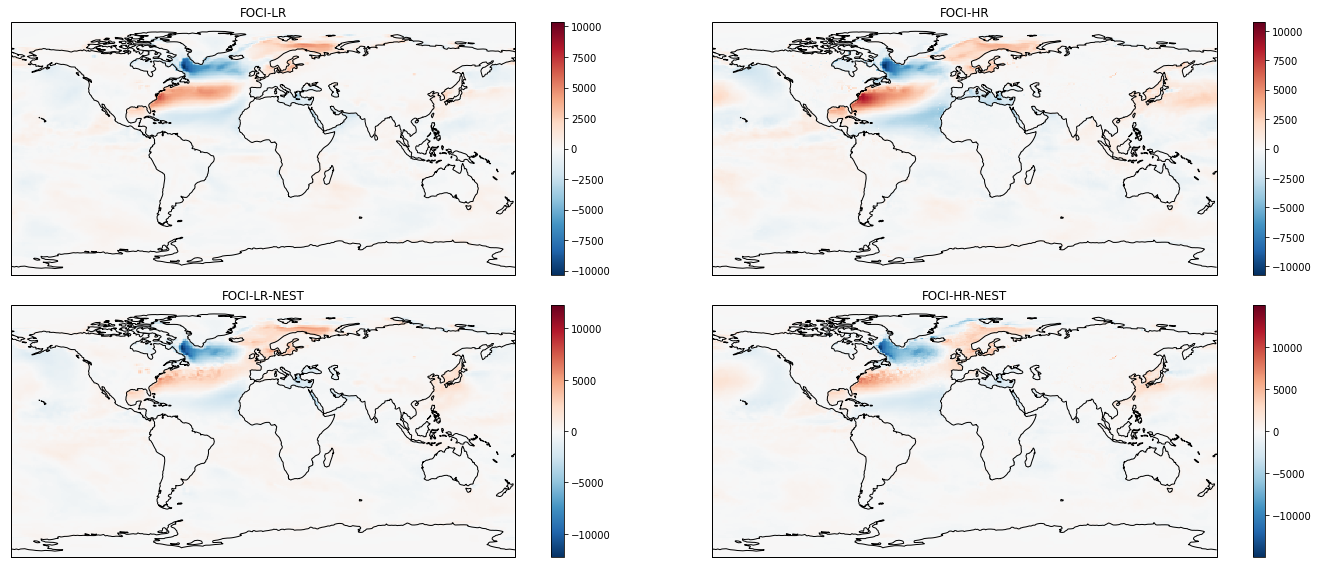

In [101]:
prj = ccrs.PlateCarree()
fig = plt.figure(figsize=(20,8))
axs = []
axs.append( fig.add_subplot(2,2,1,projection=prj) )
axs.append( fig.add_subplot(2,2,2,projection=prj) )
axs.append( fig.add_subplot(2,2,3,projection=prj) )
axs.append( fig.add_subplot(2,2,4,projection=prj) )

shf_regress_foci_lr.plot(ax=axs[0])
shf_regress_foci_hr.plot(ax=axs[1])
shf_regress_foci_lr_nest.plot(ax=axs[2])
shf_regress_foci_hr_nest.plot(ax=axs[3])

axs[0].set_title('FOCI-LR')
axs[1].set_title('FOCI-HR')
axs[2].set_title('FOCI-LR-NEST')
axs[3].set_title('FOCI-HR-NEST')

for ax in axs:
    ax.coastlines()
    
fig.tight_layout()
fig.savefig('surface_heat_flux_on_nao.png',format='png',dpi=300)

## Regress precip on NAO

In [102]:
tp_regress_foci_lr = xr.apply_ufunc(lin_regress, nao_foci_lr, tp_foci_lr_anom, 
                                     vectorize = True, dask = 'parallelized', 
                                     input_core_dims = [['time'], ['time']], output_dtypes = ['d']).compute()

tp_regress_foci_lr_nest = xr.apply_ufunc(lin_regress, nao_foci_lr_nest, tp_foci_lr_nest_anom, 
                                     vectorize = True, dask = 'parallelized', 
                                     input_core_dims = [['time'], ['time']], output_dtypes = ['d']).compute()

tp_regress_foci_hr_nest = xr.apply_ufunc(lin_regress, nao_foci_hr_nest, tp_foci_hr_nest_anom, 
                                     vectorize = True, dask = 'parallelized', 
                                     input_core_dims = [['time'], ['time']], output_dtypes = ['d']).compute()

tp_regress_foci_hr = xr.apply_ufunc(lin_regress, nao_foci_hr, tp_foci_hr_anom, 
                                     vectorize = True, dask = 'parallelized', 
                                     input_core_dims = [['time'], ['time']], output_dtypes = ['d']).compute()

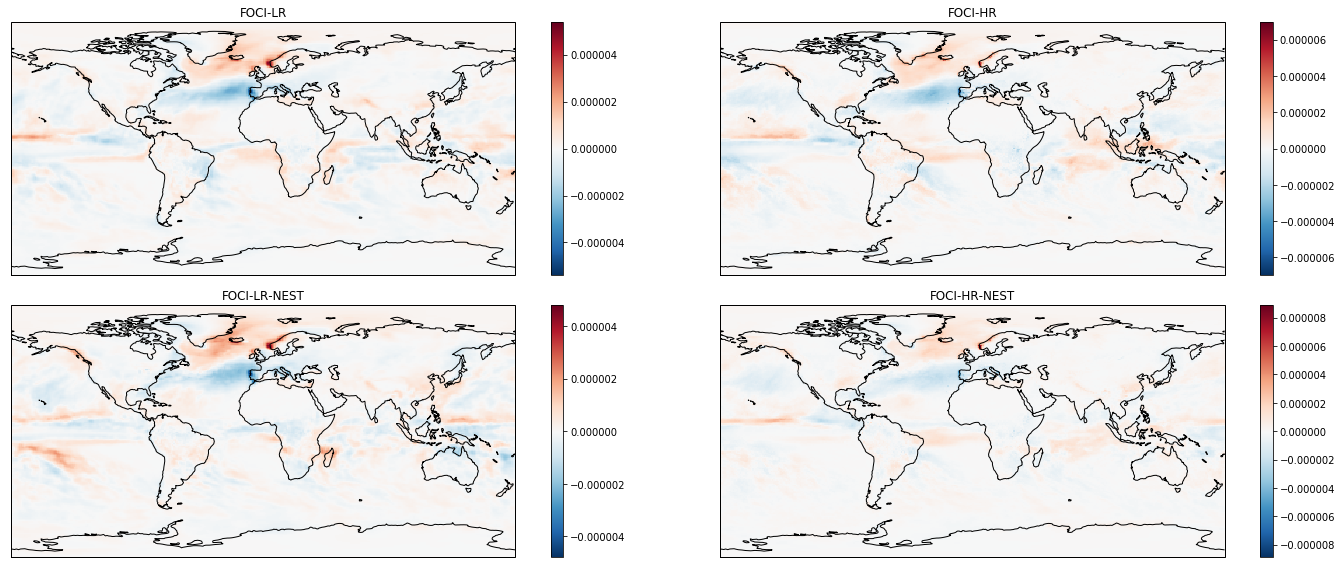

In [103]:
prj = ccrs.PlateCarree()
fig = plt.figure(figsize=(20,8))
axs = []
axs.append( fig.add_subplot(2,2,1,projection=prj) )
axs.append( fig.add_subplot(2,2,2,projection=prj) )
axs.append( fig.add_subplot(2,2,3,projection=prj) )
axs.append( fig.add_subplot(2,2,4,projection=prj) )

tp_regress_foci_lr.plot(ax=axs[0])
tp_regress_foci_hr.plot(ax=axs[1])
tp_regress_foci_lr_nest.plot(ax=axs[2])
tp_regress_foci_hr_nest.plot(ax=axs[3])

axs[0].set_title('FOCI-LR')
axs[1].set_title('FOCI-HR')
axs[2].set_title('FOCI-LR-NEST')
axs[3].set_title('FOCI-HR-NEST')

for ax in axs:
    ax.coastlines()
    
fig.tight_layout()
fig.savefig('precip_on_nao.png',format='png',dpi=300)